# Case Study 2 : Data Science in Yelp Data

**Required Readings:** 
* [Yelp Dataset Challenge](https://www.yelp.com/dataset_challenge) 
* Please download the Yelp dataset from the above webpage.
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.


** NOTE **
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

Here is an example of the data format. More details are included [here](https://www.yelp.com/dataset_challenge)

## Business Objects

Business objects contain basic information about local businesses. The fields are as follows:

```json
{
  'type': 'business',
  'business_id': (a unique identifier for this business),
  'name': (the full business name),
  'neighborhoods': (a list of neighborhood names, might be empty),
  'full_address': (localized address),
  'city': (city),
  'state': (state),
  'latitude': (latitude),
  'longitude': (longitude),
  'stars': (star rating, rounded to half-stars),
  'review_count': (review count),
  'photo_url': (photo url),
  'categories': [(localized category names)]
  'open': (is the business still open for business?),
  'schools': (nearby universities),
  'url': (yelp url)
}
```
## Checkin Objects
```json
{
    'type': 'checkin',
    'business_id': (encrypted business id),
    'checkin_info': {
        '0-0': (number of checkins from 00:00 to 01:00 on all Sundays),
        '1-0': (number of checkins from 01:00 to 02:00 on all Sundays),
        ...
        '14-4': (number of checkins from 14:00 to 15:00 on all Thursdays),
        ...
        '23-6': (number of checkins from 23:00 to 00:00 on all Saturdays)
    }, # if there was no checkin for a hour-day block it will not be in the dict
}
```

# Problem: pick a data science problem that you plan to solve using Yelp Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using yelp data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?



For the Yelp database, the review is confused. Different people has different scale to rank the restaurant. For someone, 5 is great, and 4 is good, but for others, maybe 3 is a great score. However, in the comment, in order to explain the score, the customer will contain more information.

Our problem is how to normalize the score from customers, and make the score more objective.







# Data Collection/Processing: 

The Data Collection Process started by downloading the avaiblable module "json_to_csv_converter" to convert all the json file into the csv file. Next, we change the working directory to the directory that contains all the csv file

In [1]:
import os
os.chdir('/Users/LocNguyen/Desktop/DataSci/DS501/Case Study 2/yelp-dataset')
print(os.getcwd())

/Users/LocNguyen/Desktop/DataSci/DS501/Case Study 2/yelp-dataset


In [2]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary
# Import all the require package for data analysis
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt

import collections
import re, string
import sys
import time
from nltk.corpus import stopwords
from wordcloud import WordCloud

from subprocess import check_output
%matplotlib inline

In [3]:
#Read in the yelp_business data
yelp_business = pd.read_csv("yelp_business.csv")
yelp_business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [4]:
#Read in the yelp_review data
yelp_review = pd.read_csv("yelp_review.csv")
yelp_review.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [5]:
#Read in the yelp_user data
yelp_user = pd.read_csv("yelp_user.csv")
yelp_user.head()

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,None,4,0,0,0,None,...,0,0,0,0,0,0,0,0,1,0


In [6]:
#Read in the yelp_tip data
yelp_tip = pd.read_csv("yelp_tip.csv")
yelp_tip.head()

,text,date,likes,business_id,user_id
0,Great breakfast large portions and friendly wa...,2015-08-12,0,jH19V2I9fIslnNhDzPmdkA,ZcLKXikTHYOnYt5VYRO5sg
1,Nice place. Great staff. A fixture in the tow...,2014-06-20,0,dAa0hB2yrnHzVmsCkN4YvQ,oaYhjqBbh18ZhU0bpyzSuw
2,Happy hour 5-7 Monday - Friday,2016-10-12,0,dAa0hB2yrnHzVmsCkN4YvQ,ulQ8Nyj7jCUR8M83SUMoRQ
3,"Parking is a premium, keep circling, you will ...",2017-01-28,0,ESzO3Av0b1_TzKOiqzbQYQ,ulQ8Nyj7jCUR8M83SUMoRQ
4,Homemade pasta is the best in the area,2017-02-25,0,k7WRPbDd7rztjHcGGkEjlw,ulQ8Nyj7jCUR8M83SUMoRQ


In [7]:
#Read in the yelp_checkin data
yelp_checkin = pd.read_csv("yelp_checkin.csv")
yelp_checkin.head()

,business_id,weekday,hour,checkins
0,3Mc-LxcqeguOXOVT_2ZtCg,Tue,0:00,12
1,SVFx6_epO22bZTZnKwlX7g,Wed,0:00,4
2,vW9aLivd4-IorAfStzsHww,Tue,14:00,1
3,tEzxhauTQddACyqdJ0OPEQ,Fri,19:00,1
4,CEyZU32P-vtMhgqRCaXzMA,Tue,17:00,1


# Data Exploration: Exploring the Yelp Dataset


In [8]:
#Explore the yelp review dataset

#Total Review
total_review = len(yelp_review)
print("Total Review: {}".format(total_review))

#Negative Review, if star rating less than 2
neg_review = len(yelp_review[yelp_review["stars"]<2])
print("Negative Review: {}".format(neg_review))

#Positive Review, if star rating greater than 3
pos_review = len(yelp_review[yelp_review["stars"]>3])
print("Positive Review: {}".format(pos_review))

Total Review: 5261668
Negative Review: 731363
Positive Review: 3476663


**(1) Finding the most popular business categories:** 
* print the top 10 most popular business categories in the dataset and their counts (i.e., how many business objects in each category). Here we say a category is "popular" if there are many business objects in this category (such as 'restaurants').

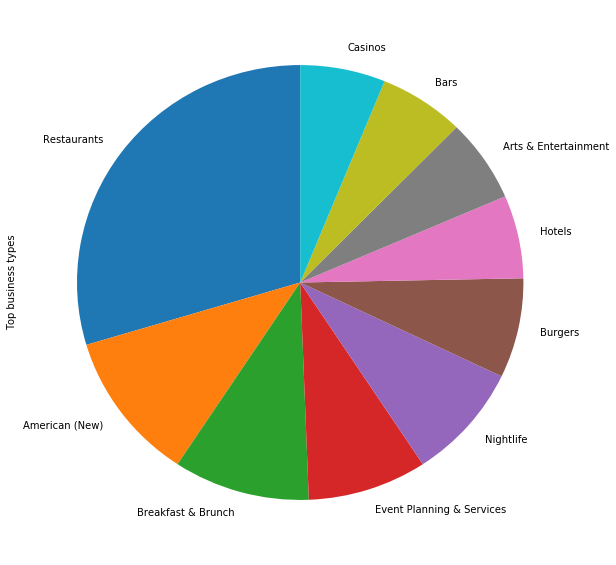

In [16]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

num_cat =10 # to show top 10 catrgories
top_business = 30 # choose categories of top 30 businesses
cat_data = top_business_data.sort_values("rated")[::-1][:top_business]
#cat_data.categories
Categories={}
for cat in cat_data.categories.values:
    all_categories= cat.split(";")
    for x in all_categories:
        try :
            Categories[x] =Categories[x]+1
        except:
            Categories[x]=1
top_categories = pd.DataFrame.from_dict(data= Categories,orient="index")
top_categories.reset_index(inplace=True)
top_categories.columns = ['category', 'occurance']

x_val=top_categories.sort_values("occurance")[::-1][:num_cat].occurance.values
labels=top_categories.sort_values("occurance")[::-1][:num_cat].category.values
series = pd.Series(x_val, index=labels, name='Top business types')
series.plot.pie(figsize=(10, 10),startangle=90)

** (2) Find the most popular business objects** 
* print the top 10 most popular business objects in the dataset and their counts (i.e., how many checkins in total for each business object).  Here we say a business object is "popular" if the business object attracts a large number of checkins from the users.

In [14]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary
# top_checkin_dict = {}

############# The code below analyze the popular based on the number of checkin ################################
# for business_id, checkins in zip(yelp_checkin['business_id'],yelp_checkin['checkins']):
#     try:
#         top_checkin_dict[business_id] = top_checkin_dict[business_id] + checkins
#     except:
#         top_checkin_dict[business_id] = checkins
        
# #Read into pandas dataframe:
# topbusiness = pd.DataFrame.from_dict(data = top_checkin_dict, orient = "index")
# topbusiness.reset_index(inplace = True)
# topbusiness.columns = ['business_id','total_checkin']

# #delete the old dictionary
# del(top_checkin_dict)
################################################################################################################


top_reviewed = yelp_review[yelp_review["stars"]>3]
top_reviews_dict ={}

for business_id in top_reviewed["business_id"].values:
    try :
        top_reviews_dict[business_id] =top_reviews_dict[business_id]+1
    except:
        top_reviews_dict[business_id]=1
        
topbusiness = pd.DataFrame.from_dict(data= top_reviews_dict,orient="index")

topbusiness.reset_index(inplace=True)
topbusiness.columns = ['business_id', 'rated']
del(top_reviews_dict)
del(top_reviewed)

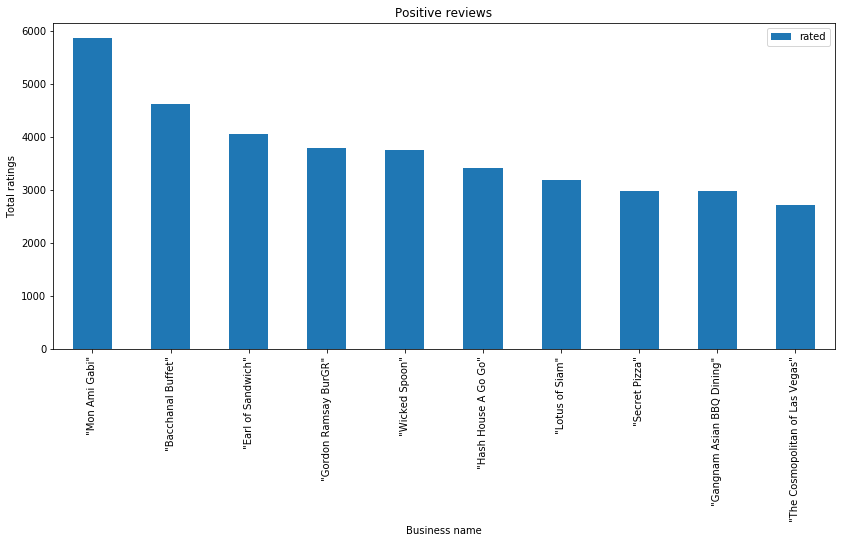

In [15]:
############# The code below analyze the popular based on the number of checkin ################################
# top_count = 10
# right=pd.DataFrame(yelp_business[['business_id',"name","categories"]].values,
#                     columns=['business_id',"Business name","categories"])

# top_business_data = pd.merge(topbusiness,right=right, how="inner",on='business_id')

# top_business_data.sort_values("total_checkin")[::-1][:top_count].plot(x="Business name",y="total_checkin", 
#                                                    kind="bar",figsize=(14,6),
#                                                    title='Top 10 Most Popular Business Objects').set_ylabel("Total Check-in")

# del(topbusiness)
# del(right)
#######################################################################################

top_count= 10
right=pd.DataFrame(yelp_business[['business_id',"name","categories"]].values,
                    columns=['business_id',"Business name","categories"])

top_business_data = pd.merge(topbusiness,right=right, how="inner",on='business_id')
top_business_data.sort_values("rated")[::-1][:top_count].plot(x="Business name",y="rated", 
                                                   kind="bar",figsize=(14,6),
                                                   title='Positive reviews').set_ylabel("Total ratings")

del(topbusiness)
del(right)

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

In order to solve the problem, we use Yelp dataset to analyze and make an algorithm to optimize and normalize the score.

Related Process:
- find a normalize standard
- compare the users' comments with the standard
- predict the score the customer will give
- make a normalized score with an algorithm

Information of the algorithm:
- We use sentiment analysis to analyze 10000 customers review in the restaurants in Las Vegas, which city has a lot of restaurants(26776). We found the relationship of comments and star rank.
- For those whose sentiment score is around -0.03737056347222962, most tend to give 1 star, around 0.09496182513589005 is 2 star, around 0.17643774101867815 is 3 star, around 0.2707158060193166 is 4 star, and around 0.34842419775482253 is 5 star.

In our algorithm, the clarification standards are determined by the average of the mean for each star rank box.

The normalize score algorithm is an equation:
new star = 0.5 x old star + 0.5 x predicted star

In the future, when customers finish writing the comments, the system will predict a score for customer using sentiment analysis. Then the customer could adjust the star rank. Finally, the ratio will be changed to the fittest number.

Write codes to implement the solution in python:

In [1]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary


# read the first 1000000 review data from review.json
from textblob import TextBlob
import json

data_review = []
with open('review.json') as f:
    ct = 0
    for line in f:
        if ct < 1000000:
            data_review.append(json.loads(line))
            ct += 1
        else:
            break

print 'Read in review.json over'
print 'review number: ', len(data_review)

Read in review.json over
review number:  1000000


In [2]:
import json

# read from business.json
data_business = []
with open('business.json') as f:
    for line in f:
        data_business.append(json.loads(line))
print 'Read in business.json over'
print 'business ID number: ', len(data_business)

Read in business.json over
business ID number:  174567


In [3]:
business_id = []
business_name = []
city = 'Las Vegas'
state = ''

# get business info of specific city or state
for business in data_business:
    if business['city'] == city or business['state'] == state:
        business_id.append(business['business_id'])
        business_name.append(business['name'])
dict_id_name = dict(zip(business_id, business_name))
print 'number of restaurants in ', city, ': ', len(business_id)
print 'over'

number of restaurants in  Las Vegas :  26776
over


In [4]:
stars = []
sentiment_list = []

# sentiment of the first 10000 review in the city decided
ct = 0
for item in data_review:
    if ct < 10000:
        if item['business_id'] in business_id:
            blob = TextBlob(item['text'])
            stars.append(int(item['stars']))
            sentiment_list.append(float(blob.sentiment[0]))
#             print item['business_id']
            ct += 1
    else:
        break
#         business_name = dict_id_name[item['business_id']]
#         print '[', business_name, ': ', item['text'], ' | ', blob.sentiment, ' | ', item['stars'],']'

print 'data of stars: ',len(stars)
print 'data of sentiment: ',len(sentiment_list)
print 'over'

data of stars:  10000
data of sentiment:  10000
over


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# clarify the distribution of sentiment score in each star rank
box1 = []
box2 = []
box3 = []
box4 = []
box5 = []
labels = ['1', '2', '3', '4', '5']
for star_score_index in range(len(stars)):
    if stars[star_score_index] == 1:
        box1.append(sentiment_list[star_score_index])
    elif stars[star_score_index] == 2:
        box2.append(sentiment_list[star_score_index])
    elif stars[star_score_index] == 3:
        box3.append(sentiment_list[star_score_index])
    elif stars[star_score_index] == 4:
        box4.append(sentiment_list[star_score_index])
    elif stars[star_score_index] == 5:
        box5.append(sentiment_list[star_score_index])

# list for mean deviation
var_mean_data = []
var_mean_data.append(np.mean(box1))
var_mean_data.append(np.mean(box2))
var_mean_data.append(np.mean(box3))
var_mean_data.append(np.mean(box4))
var_mean_data.append(np.mean(box5))

# list for median devidation
var_median_data = []
var_median_data.append(np.median(box1))
var_median_data.append(np.median(box2))
var_median_data.append(np.median(box3))
var_median_data.append(np.median(box4))
var_median_data.append(np.median(box5))

print 'means variation: ', np.var(var_mean_data)
print 'median variation: ', np.var(var_median_data)
print 'means\' variation is larger than medians\', which means means can show the difference of the sentiment score\n'

# statistic information for each star rank
print 'scores for star 1: mean: ', np.mean(box1), '   |   median: ',np.median(box1)
print '                  ','25 percentile: ',np.percentile(box1, 25),'   |   75 percentile: ', np.percentile(box1, 75)
print 'scores for star 2: mean: ', np.mean(box2), '   |   median: ',np.median(box2)
print '                  ','25 percentile: ',np.percentile(box2, 25),'   |   75 percentile: ', np.percentile(box2, 75)
print 'scores for star 3: mean:  ', np.mean(box3), '   |   median: ',np.median(box3)
print '                  ','25 percentile: ',np.percentile(box3, 25),'   |   75 percentile: ', np.percentile(box3, 75)
print 'scores for star 4: mean: ', np.mean(box4), '   |   median: ',np.median(box4)
print '                  ','25 percentile: ',np.percentile(box4, 25),'   |   75 percentile: ', np.percentile(box4, 75)
print 'scores for star 5: mean:  ', np.mean(box5), '   |   median: ',np.median(box5)
print '                  ','25 percentile: ',np.percentile(box5, 25),'   |   75 percentile: ', np.percentile(box5, 75)

means variation:  0.01813031643946774
median variation:  0.014373495298596444
means' variation is larger than medians', which means means can show the difference of the sentiment score

scores for star 1: mean:  -0.03737056347222962    |   median:  -0.00949494949494948
                   25 percentile:  -0.13437763047138046    |   75 percentile:  0.085
scores for star 2: mean:  0.09496182513589005    |   median:  0.09591450216450216
                   25 percentile:  0.007105654761904761    |   75 percentile:  0.18798260381593712
scores for star 3: mean:   0.17643774101867815    |   median:  0.16286130536130536
                   25 percentile:  0.09048266045548656    |   75 percentile:  0.25416666666666665
scores for star 4: mean:  0.2707158060193166    |   median:  0.2563481660551038
                   25 percentile:  0.17400219298245614    |   75 percentile:  0.351468253968254
scores for star 5: mean:   0.34842419775482253    |   median:  0.3333333333333333
                   25 per

In [12]:
# algorithm part

# star rank generate function
def sentiment_star(sentiment_score):
    predict_star = 0
    if sentiment_score < (np.mean(box1) + np.mean(box2)/ 2):
        predict_star = 1
    elif sentiment_score < (np.mean(box2) + np.mean(box3)/ 2):
        predict_star = 2
    elif sentiment_score < (np.mean(box3) + np.mean(box4)/ 2):
        predict_star = 3
    elif sentiment_score < (np.mean(box4) + np.mean(box5)/ 2):
        predict_star = 4
    elif sentiment_score >= (np.mean(box4) + np.mean(box5)/ 2):
        predict_star = 5
    
    return predict_star

# star rank renewal function
def star_renewal(old_star, predicted_star):
    new_star = 0
    new_star = 0.5*old_star + 0.5*predicted_star
        
    return new_star

# example
# renewal the star of the first 10000 review in the city decided
stars_new = []
sentiment_list_new = []

ct = 0
for item in data_review:
    if ct < 10000:
        if item['business_id'] in business_id:
            new_star = 0.
            blob = TextBlob(item['text'])
            business_name = dict_id_name[item['business_id']]
            # It is the same as the previous sentiment analysis, just calculate again for safely match the star rank with the sentiment score
            sentiment_list_new.append(float(blob.sentiment[0]))
#             print item['business_id']
            new_star = star_renewal(item['stars'], sentiment_star(blob.sentiment[0]))
#             print '[', business_name, ':', item['text'], blob.sentiment[0], ' | old star: ', item['stars'], ' | new star: ', new_star, ']'
#             if ct < 20:
#                 print '[',item['text'], ']\n[', blob.sentiment[0], ' | old star: ', item['stars'], ' | new star: ', new_star,' | predict star', sentiment_star(blob.sentiment[0]), ']'
            stars_new.append(new_star)
            ct += 1
    else:
        break

print 'data of renewal stars: ',len(stars_new)
print 'data of sentiment: ',len(sentiment_list_new)
print 'over'

data of renewal stars:  10000
data of sentiment:  10000
over


# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


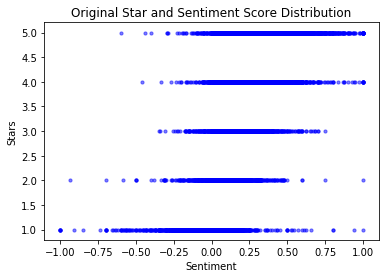

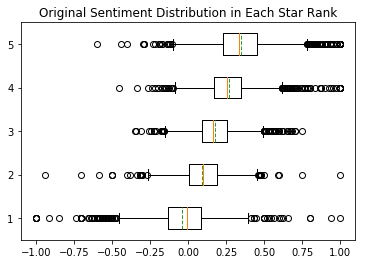

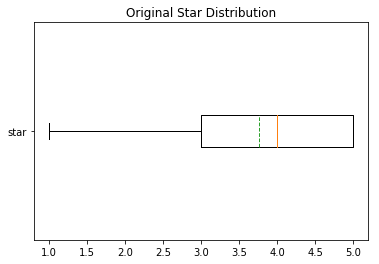

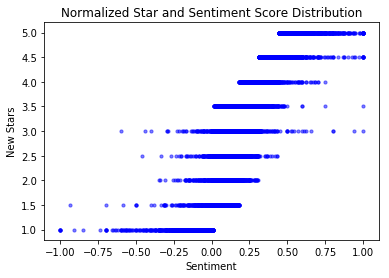

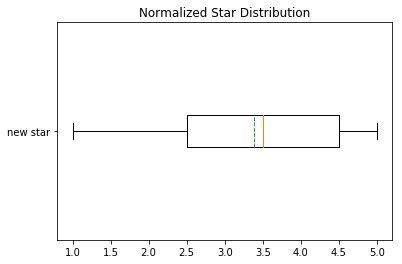

In [13]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# scatter of stars and sentiment score
X = sentiment_list
Y = stars

scatter = plt.gca()
plt.title('Original Star and Sentiment Score Distribution')
scatter.set_xlabel('Sentiment')
scatter.set_ylabel('Stars')
scatter.scatter(X, Y, c='b', s=10, alpha=.5)

plt.savefig("scatter.png")
plt.show()

# draw the box plot for the sentiment score
data = [box1, box2, box3, box4, box5]

plt.title('Original Sentiment Distribution in Each Star Rank')
plt.boxplot(data, labels = labels, sym = "o", showmeans=True, meanline=True, vert = False)
plt.savefig("boxplot_sentiment.png")
plt.show()

# show the original stars distribution in the review data
plt.title('Original Star Distribution')
plt.boxplot(stars, labels = ['star'], sym = "o", showmeans=True, meanline=True, vert = False)
plt.savefig("boxplot_stars.png")
plt.show()



# scatter of new stars and sentiment score
X2 = sentiment_list_new
Y2 = stars_new

scatter_new = plt.gca()
plt.title('Normalized Star and Sentiment Score Distribution')
scatter_new.set_xlabel('Sentiment')
scatter_new.set_ylabel('New Stars')
scatter_new.scatter(X2, Y2, c='b', s=10, alpha=.5)

plt.savefig("scatter_new.png")
plt.show()

# show the new stars distribution in the review data
plt.title('Normalized Star Distribution')
plt.boxplot(stars_new, labels = ['new star'], sym = "o", showmeans=True, meanline=True, vert = False)
plt.savefig("boxplot_star_new.png")
plt.show()

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 2".
        
** Note: Each team only needs to submit one submission in Canvas **


# Peer-Review Grading Template:

** Total Points: (100 points) ** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (10 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       2: I can barely understand what data they are trying to collect/process
       4: I can barely understand why the data is relevant to the problem
       6: the data are relevant to the problem, but better data can be collected
       8: the data collected are relevant and at a proper scale
      10: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the following task:
    
    (1) Finding the most popular business categories (5 points):
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect
    
    (2) Find the most popular business objects (5 points)
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect
    
    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    1. [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        
    2. [Presentation] Among all the teams in the presentation, which team do you think deserves the best presentation award for this case study?  
        1: Team 1
        2: Team 2
        3: Team 3
        4: Team 4
        5: Team 5
        6: Team 6
        7: Team 7
        8: Team 8
        9: Team 9


